# 라이브러리 불러오기

In [2]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# EDA 지도 데이터용
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.neighbors import BallTree




ModuleNotFoundError: No module named 'folium'

# 랜덤 시드 설정

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [4]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/train.csv'

## 금리, 공원, 학교, 지하철 불러오기

In [ ]:
interest_data = pd.read_csv('data/interestRate.csv')
park_data = pd.read_csv('data/parkInfo.csv')
school_data = pd.read_csv('data/schoolinfo.csv')
subway_data = pd.read_csv('data/subwayInfo.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/interestRate.csv'

In [6]:
train_data.head(10)

index  area_m2  contract_year_month  contract_day  contract_type  floor  \
0      0  84.9981               201906            25              2      9   
1      1  84.9981               202003            26              2     20   
2      2  84.9981               202003            28              2      8   
3      3  59.3400               201907            15              2      1   
4      4  59.8100               201904            12              2      6   
5      5  84.9342               201904            26              2     13   
6      6  39.2700               201905             7              2      3   
7      7  84.9342               201905             9              2      3   
8      8  84.9610               201905            25              2      3   
9      9  84.9182               201905            25              2     13   

   built_year   latitude   longitude  age  deposit  
0        2019  37.054314  127.045216    0  17000.0  
1        2019  37.054314  127.045216    1  23000.0  
2        2019  37.054314  127.045216    1  23000.0  
3        1986  36.964647  127.055847   33   5000.0  
4        1995  36.972390  127.084514   24   1800.0  
5        2016  36.965423  127.048779    3  20000.0  
6        1990  36.957089  127.047449   29   4000.0  
7        2016  36.965423  127.048779    3  20000.0  
8        2016  36.965423  127.048779    3  20500.0  
9        2016  36.965423  127.048779    3  19000.0

# 데이터 EDA 수행하기

## 지도 그려보기

In [ ]:
# 결측치 확인
train_data.isna().sum()

index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
deposit                0
dtype: int64

In [ ]:
test_data.isna().sum()

index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
dtype: int64

In [ ]:
print(interest_data.isna().sum())
print(park_data.isna().sum())
print(school_data.isna().sum())
print(subway_data.isna().sum())

year_month       0
interest_rate    0
dtype: int64
latitude     0
longitude    0
area         0
dtype: int64
schoolLevel    0
latitude       0
longitude      0
dtype: int64
latitude     0
longitude    0
dtype: int64


### 기본적인 통계량 확인

eda를 원활하게 하기 위해 면적의 영향을 줄이기 위해 면적당 가격 변수 생성

In [8]:
train_data['deposit_per_m2'] = train_data['deposit'] / train_data['area_m2']

In [ ]:
train_data.describe()

index       area_m2  contract_year_month  contract_day  \
count  1.801228e+06  1.801228e+06         1.801228e+06  1.801228e+06   
mean   9.006135e+05  7.518833e+01         2.021331e+05  1.589943e+01   
std    5.199699e+05  2.552632e+01         1.352815e+02  8.625998e+00   
min    0.000000e+00  1.032150e+01         2.019040e+05  1.000000e+00   
25%    4.503068e+05  5.975000e+01         2.020080e+05  9.000000e+00   
50%    9.006135e+05  7.715000e+01         2.021110e+05  1.600000e+01   
75%    1.350920e+06  8.496000e+01         2.022120e+05  2.300000e+01   
max    1.801227e+06  3.173600e+02         2.023120e+05  3.100000e+01   

       contract_type         floor    built_year      latitude     longitude  \
count   1.801228e+06  1.801228e+06  1.801228e+06  1.801228e+06  1.801228e+06   
mean    1.203805e+00  1.005197e+01  2.004199e+03  3.747721e+01  1.269662e+02   
std     8.852792e-01  6.973359e+00  1.115132e+01  1.625113e-01  1.701221e-01   
min     0.000000e+00 -4.000000e+00  1.961000e+03  3.691791e+01  1.264787e+02   
25%     0.000000e+00  5.000000e+00  1.995000e+03  3.737976e+01  1.268422e+02   
50%     2.000000e+00  9.000000e+00  2.004000e+03  3.750227e+01  1.269976e+02   
75%     2.000000e+00  1.400000e+01  2.015000e+03  3.758205e+01  1.270888e+02   
max     2.000000e+00  6.800000e+01  2.024000e+03  3.818194e+01  1.276609e+02   

                age       deposit  deposit_per_m2  
count  1.801228e+06  1.801228e+06    1.801228e+06  
mean   1.706597e+01  3.816223e+04    5.084894e+02  
std    1.112796e+01  2.610377e+04    2.733029e+02  
min   -3.000000e+00  3.000000e+02    6.349206e+00  
25%    7.000000e+00  2.100000e+04    3.232317e+02  
50%    1.700000e+01  3.200000e+04    4.472482e+02  
75%    2.600000e+01  4.780000e+04    6.298679e+02  
max    6.200000e+01  1.100000e+06    1.005025e+04

In [ ]:
test_data.describe()

index        area_m2  contract_year_month   contract_day  \
count  150172.00000  150172.000000        150172.000000  150172.000000   
mean    75085.50000      74.509956        202403.137576      14.816650   
std     43351.06665      23.971424             1.645994       8.537693   
min         0.00000      10.780000        202401.000000       1.000000   
25%     37542.75000      59.760000        202402.000000       7.000000   
50%     75085.50000      75.793700        202403.000000      15.000000   
75%    112628.25000      84.958200        202405.000000      22.000000   
max    150171.00000     273.860000        202406.000000      31.000000   

       contract_type          floor     built_year       latitude  \
count  150172.000000  150172.000000  150172.000000  150172.000000   
mean        0.426071      10.060557    2004.908292      37.474571   
std         0.597423       6.982813      11.460352       0.166952   
min         0.000000      -3.000000    1966.000000      36.957089   
25%         0.000000       5.000000    1995.000000      37.372616   
50%         0.000000       9.000000    2004.000000      37.500382   
75%         1.000000      14.000000    2016.000000      37.588872   
max         2.000000      60.000000    2024.000000      38.106033   

           longitude            age  
count  150172.000000  150172.000000  
mean      126.967625      19.091708  
std         0.172066      11.460352  
min       126.478708       0.000000  
25%       126.841057       8.000000  
50%       126.998922      20.000000  
75%       127.091862      29.000000  
max       127.660896      58.000000

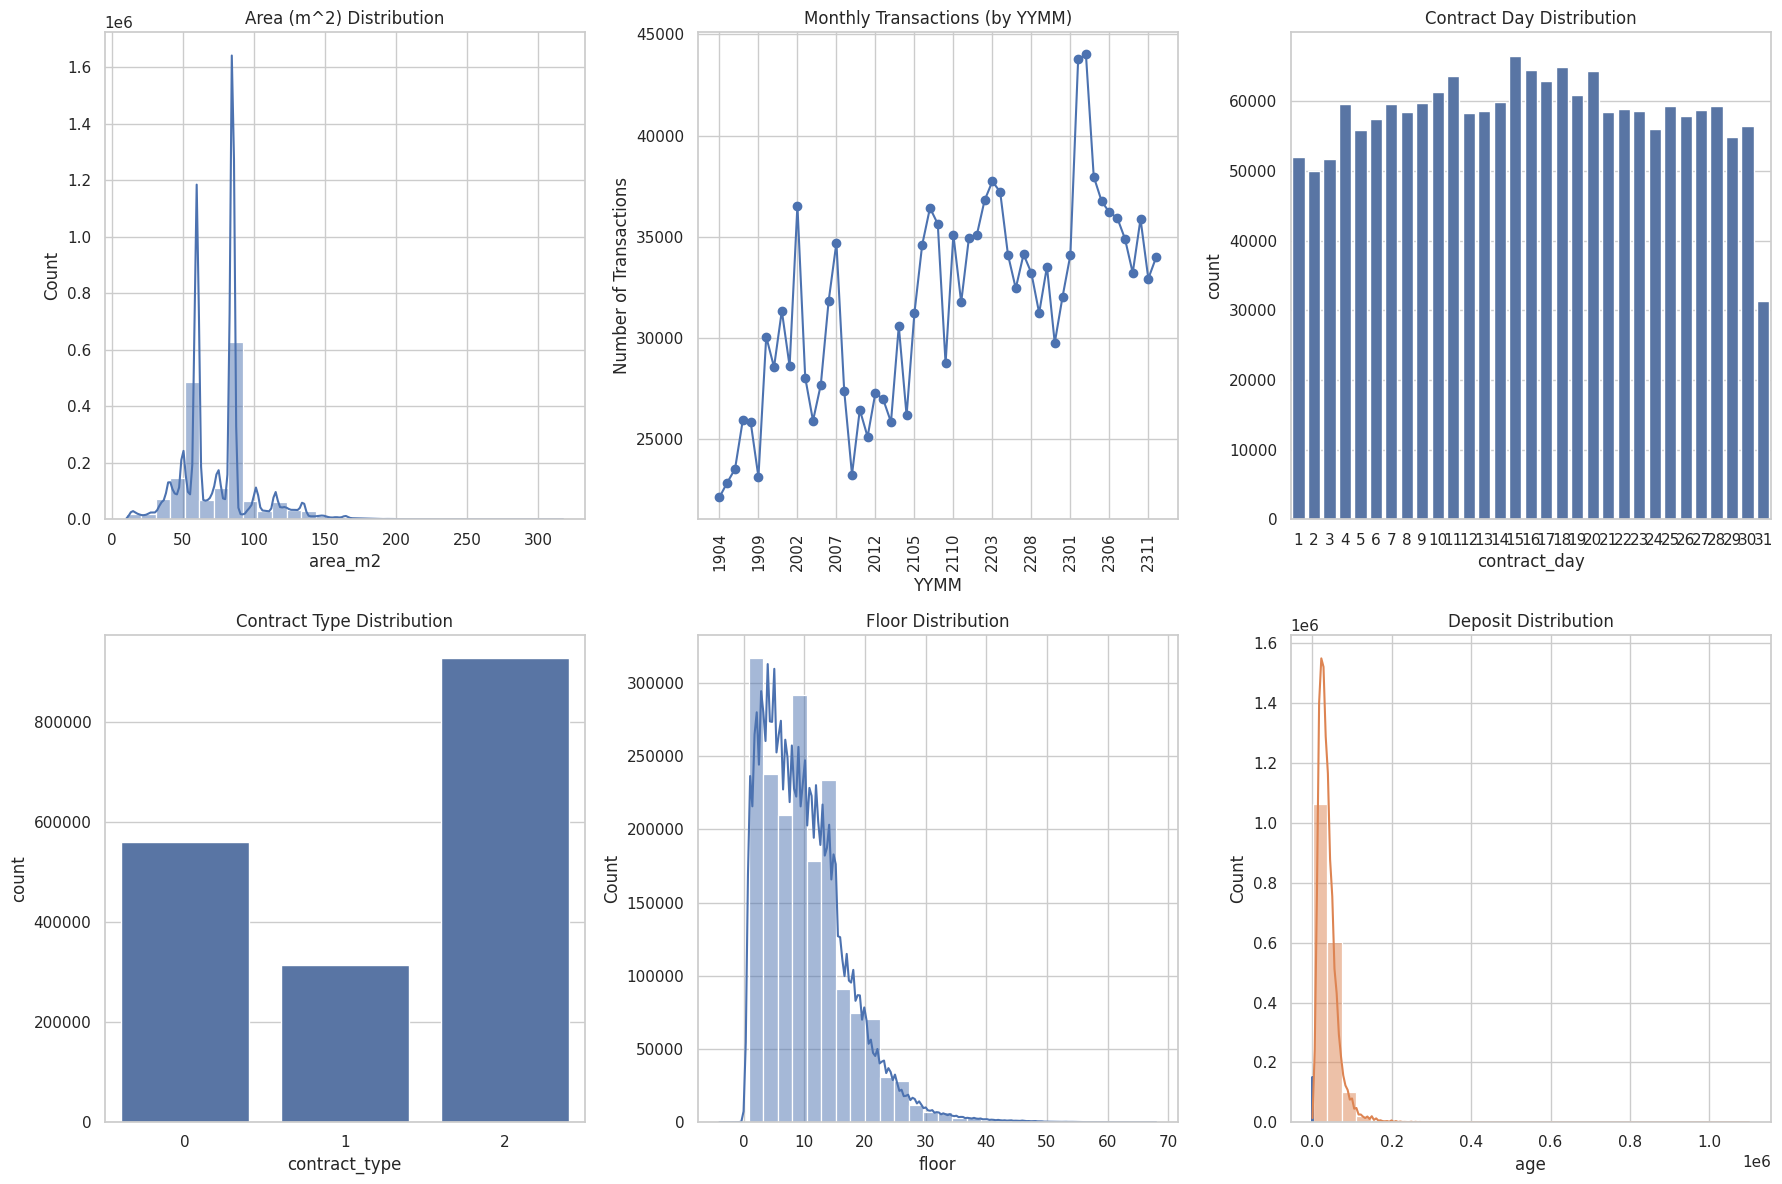

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 그래프를 여러 개 배치할 수 있는 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# 각 변수에 대해 분포 그리기
sns.histplot(train_data['area_m2'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Area (m^2) Distribution')

# contract_year_month를 "YYMM" 형식으로 변환
train_data['contract_year_month'] = train_data['contract_year_month'].astype(str)
train_data['YYMM'] = train_data['contract_year_month'].apply(lambda x: x[2:])

# 월별로 그룹화하고 거래량 계산
monthly_transactions = train_data.groupby('YYMM').size()

# 선그래프 그리기
axes[0, 1].plot(monthly_transactions.index, monthly_transactions.values, marker='o', linestyle='-')
axes[0, 1].set_title('Monthly Transactions (by YYMM)')
axes[0, 1].set_xlabel('YYMM')
axes[0, 1].set_ylabel('Number of Transactions')

# x축 레이블을 간격에 맞춰 표시 (간격을 조정하여 레이블을 줄임)
step = max(1, len(monthly_transactions) // 10)  # 10개의 레이블만 표시
axes[0, 1].set_xticks(axes[0, 1].get_xticks()[::step])
axes[0, 1].tick_params(axis='x', rotation=90)

sns.countplot(x=train_data['contract_day'], ax=axes[0, 2])
axes[0, 2].set_title('Contract Day Distribution')

sns.countplot(x=train_data['contract_type'], ax=axes[1, 0])
axes[1, 0].set_title('Contract Type Distribution')

sns.histplot(train_data['floor'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Floor Distribution')

sns.histplot(train_data['age'], bins=30, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Building Age Distribution')

# deposit 분포 추가
sns.histplot(train_data['deposit'], bins=30, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Deposit Distribution')

# 레이아웃 조정
plt.tight_layout()
plt.show()



계약 건물 나이 분포

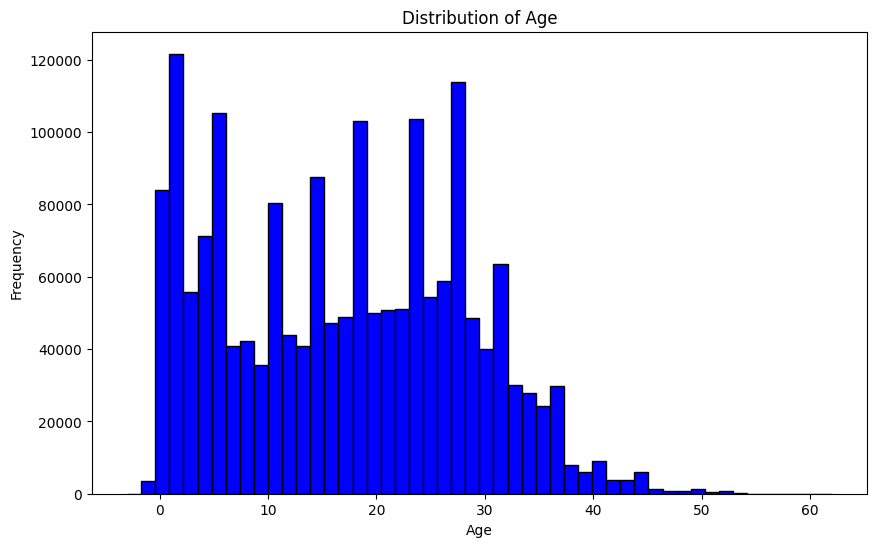

In [ ]:
# Age graph
plt.figure(figsize=(10, 6))
train_data['age'].hist(bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


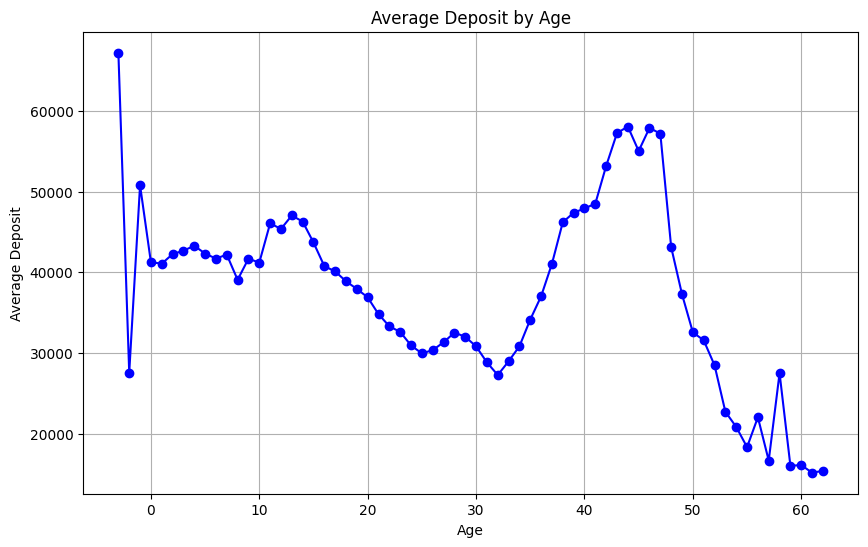

In [ ]:
# Grouping by 'age' and calculating the mean of 'deposit'
age_deposit_avg = train_data.groupby('age')['deposit'].mean().reset_index()

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(age_deposit_avg['age'], age_deposit_avg['deposit'], marker='o', color='blue')
plt.title('Average Deposit by Age')
plt.xlabel('Age')
plt.ylabel('Average Deposit')
plt.grid(True)
plt.show()

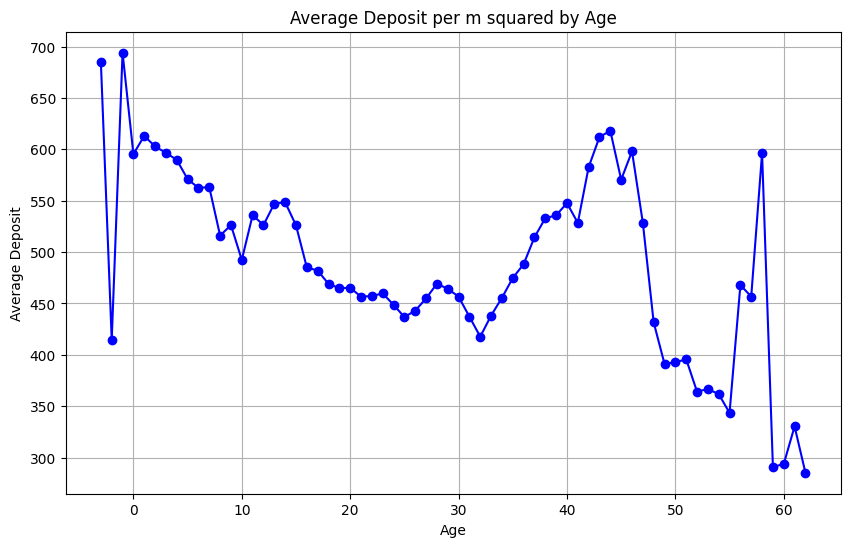

In [ ]:
# Grouping by 'age' and calculating the mean of 'deposit_per_m2'
age_deposit_avg = train_data.groupby('age')['deposit_per_m2'].mean().reset_index()

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(age_deposit_avg['age'], age_deposit_avg['deposit_per_m2'], marker='o', color='blue')
plt.title('Average Deposit per m squared by Age')
plt.xlabel('Age')
plt.ylabel('Average Deposit')
plt.grid(True)
plt.show()

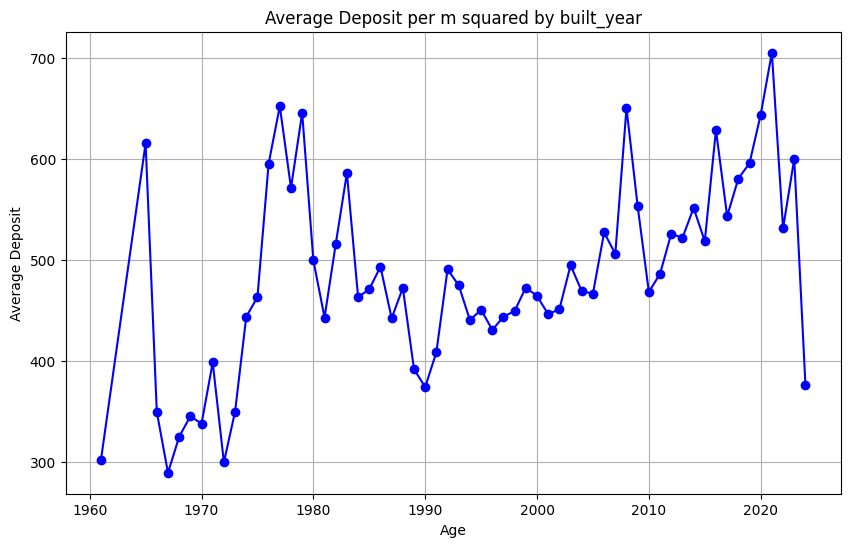

In [19]:
# Grouping by 'built_year' and calculating the mean of 'deposit_per_m2'
age_deposit_avg = train_data.groupby('built_year')['deposit_per_m2'].mean().reset_index()

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(age_deposit_avg['built_year'], age_deposit_avg['deposit_per_m2'], marker='o', color='blue')
plt.title('Average Deposit per m squared by built_year')
plt.xlabel('Age')
plt.ylabel('Average Deposit')
plt.grid(True)
plt.show()

In [24]:
train_data[(train_data['built_year'] == 2021)].describe()

index       area_m2  contract_year_month  contract_day  \
count  4.389400e+04  43894.000000         43894.000000  43894.000000   
mean   9.403912e+05     69.491914        202208.914863     15.664533   
std    4.788916e+05     20.453422            91.394795      8.493034   
min    6.101000e+03     11.330000        201905.000000      1.000000   
25%    4.942582e+05     59.888300        202109.000000      9.000000   
50%    8.353805e+05     70.540000        202205.000000     16.000000   
75%    1.391762e+06     84.939650        202305.000000     23.000000   
max    1.798701e+06    162.829000        202312.000000     31.000000   

       contract_type         floor  built_year      latitude     longitude  \
count   43894.000000  43894.000000     43894.0  43894.000000  43894.000000   
mean        0.703171     12.465326      2021.0     37.463116    126.989606   
std         0.875703      7.839447         0.0      0.178904      0.165128   
min         0.000000     -2.000000      2021.0     36.987751    126.506552   
25%         0.000000      6.000000      2021.0     37.372616    126.899649   
50%         0.000000     11.000000      2021.0     37.492920    126.998949   
75%         2.000000     17.000000      2021.0     37.580758    127.100963   
max         2.000000     49.000000      2021.0     37.888228    127.635053   

                age        deposit  deposit_per_m2  
count  43894.000000   43894.000000    43894.000000  
mean       1.025174   47933.012735      704.952962  
std        0.919234   29635.235210      356.473888  
min       -2.000000    1000.000000       16.680845  
25%        0.000000   29000.000000      450.408538  
50%        1.000000   40000.000000      624.037796  
75%        2.000000   60000.000000      835.872613  
max        2.000000  405000.000000     3743.448964

In [23]:
train_data[(train_data['built_year'] == 1977)].describe()

index      area_m2  contract_year_month  contract_day  \
count  2.046000e+03  2046.000000          2046.000000   2046.000000   
mean   1.293680e+06    78.142671        202127.230694     15.334800   
std    1.922085e+05    31.166133           138.226244      8.628991   
min    9.464900e+05    40.460000        201904.000000      1.000000   
25%    1.141107e+06    52.890000        202007.000000      8.000000   
50%    1.302198e+06    78.050000        202110.000000     15.000000   
75%    1.455660e+06    89.920000        202212.000000     23.000000   
max    1.726600e+06   197.460000        202312.000000     31.000000   

       contract_type        floor  built_year     latitude    longitude  \
count    2046.000000  2046.000000      2046.0  2046.000000  2046.000000   
mean        1.245846     5.996579      1977.0    37.530496   126.984798   
std         0.853968     3.427843         0.0     0.021249     0.055380   
min         0.000000     1.000000      1977.0    37.472420   126.619309   
25%         0.000000     3.000000      1977.0    37.524533   126.932948   
50%         2.000000     6.000000      1977.0    37.530350   127.002356   
75%         2.000000     9.000000      1977.0    37.532056   127.039294   
max         2.000000    14.000000      1977.0    37.616768   127.039294   

               age        deposit  deposit_per_m2  
count  2046.000000    2046.000000     2046.000000  
mean     44.204790   51061.504888      652.072580  
std       1.386839   27184.200729      259.974819  
min      42.000000    3000.000000       71.959703  
25%      43.000000   33000.000000      451.689612  
50%      44.000000   47250.000000      672.193592  
75%      45.000000   65000.000000      814.153750  
max      46.000000  170000.000000     1459.321416

건물의 나이에 따른 집값 분포에서 0이 상대적으로 낮고 물량 또한 10%를 차지하면서 중요한 정보입니다.

### 이상치 확인

통계량 상 floor 와 age가 도메인 지식과 상응되는 점 확인 따라서, 분석이 더 필요합니다

In [ ]:
# 나이가 0보다 작은 데이터 필터링
negative_age_data = train_data[train_data['age'] < -1]

# 고유한 latitude와 longitude 추출
unique_lat_long = negative_age_data[['latitude', 'longitude']].drop_duplicates()

# 고유한 latitude와 longitude 출력
unique_lat_long


latitude   longitude
6101     37.690500  127.211147
6153     37.690810  127.212458
20210    37.723645  127.057603
28858    37.022348  127.093319
31588    37.428620  126.998875
342909   37.001944  127.157404
445834   37.816934  127.056850
536611   37.270556  127.070720
537054   37.297819  127.119310
968419   37.618263  127.053335
987149   37.595555  126.923904
1027954  37.503153  126.907633
1112268  37.538617  127.082375
1168345  37.551166  126.949556
1309325  37.580081  126.903417

In [ ]:
# 특정 위도와 경도 값
target_latitude = 37.618263
target_longitude = 127.053335


# np.isclose를 사용하여 근사값 비교로 데이터 필터링
specific_apartment_data = train_data[np.isclose(train_data['latitude'], target_latitude) & np.isclose(train_data['longitude'], target_longitude)]

specific_apartment_data.head(20)

index  area_m2 contract_year_month  contract_day  contract_type  \
968419    968419    84.97              201906            18              2   
968905    968905    59.92              201910            29              2   
968956    968956    59.92              201911            23              2   
1207526  1207526    59.92              202105             8              2   
1208161  1208161    59.92              202105            15              2   
1210271  1210271    59.92              202106            11              1   
1210364  1210364    59.92              202106            12              1   
1210768  1210768    59.92              202106            17              1   
1210861  1210861    59.92              202106            18              1   
1211206  1211206    59.92              202106            21              1   
1211339  1211339    59.92              202106            22              1   
1212304  1212304    84.97              202107             5              0   
1212688  1212688    84.97              202107            10              1   
1212847  1212847    84.97              202107            10              0   
1212871  1212871    59.92              202107            12              1   
1213506  1213506    84.97              202107            20              1   
1213994  1213994    84.97              202107            25              1   
1214800  1214800    84.97              202108             7              1   
1215106  1215106    84.97              202108            10              1   
1215188  1215188    59.92              202108            10              2   

         floor  built_year   latitude   longitude  age  deposit  YYMM  
968419      10        2021  37.618263  127.053335   -2  33000.0  1906  
968905       5        2019  37.618263  127.053335    0  35000.0  1910  
968956       8        2019  37.618263  127.053335    0  30000.0  1911  
1207526      6        2019  37.618263  127.053335    2  53000.0  2105  
1208161     15        2021  37.618263  127.053335    0  45000.0  2105  
1210271     21        2021  37.618263  127.053335    0  31500.0  2106  
1210364      6        2019  37.618263  127.053335    2  36750.0  2106  
1210768      8        2021  37.618263  127.053335    0  46000.0  2106  
1210861      9        2021  37.618263  127.053335    0  31500.0  2106  
1211206      5        2021  37.618263  127.053335    0  31500.0  2106  
1211339     14        2021  37.618263  127.053335    0  31500.0  2106  
1212304     25        2021  37.618263  127.053335    0  68500.0  2107  
1212688     19        2021  37.618263  127.053335    0  45000.0  2107  
1212847      5        2021  37.618263  127.053335    0  68000.0  2107  
1212871     18        2021  37.618263  127.053335    0  31500.0  2107  
1213506      8        2021  37.618263  127.053335    0  39900.0  2107  
1213994     23        2021  37.618263  127.053335    0  38800.0  2107  
1214800      8        2021  37.618263  127.053335    0  37800.0  2108  
1215106     23        2021  37.618263  127.053335    0  40950.0  2108  
1215188     16        2021  37.618263  127.053335    0  35700.0  2108

확인 결과 age가 - 인 데이터는 정상적. 입주 기간이 늦어지거나 공공 민간임대인 경우도 있고 건축 연도가 실제로 계약 시작일로부터 age만큼 후랑 맞음

In [ ]:
# 층이 0보다 작은 데이터 필터링
train_data[train_data['floor'] <= 0].shape

(70, 12)

확인결과 0 이하 의 개수는 66개, 십만개의 데이타에 비하면 굉장히 적지만 확인 필요

In [ ]:
# 층이 0 이하인 데이터 필터링
low_floor_data = train_data[train_data['floor'] <= 0]

# 같은 위도, 경도, 면적을 가진 다른 거래와 비교하기 위해 데이터 그룹화
# floor가 0 이하인 거래의 고유한 위도, 경도, 면적 추출
unique_properties = low_floor_data[['latitude', 'longitude', 'area_m2']].drop_duplicates()

# 결과를 저장할 리스트
comparison_results = []

# 고유한 위도, 경도, 면적을 가진 다른 거래와 비교
for index, row in unique_properties.iterrows():
    # 같은 위도, 경도, 면적을 가진 모든 거래 추출
    similar_transactions = train_data[
        (train_data['latitude'] == row['latitude']) &
        (train_data['longitude'] == row['longitude']) &
        (train_data['area_m2'] == row['area_m2'])
    ]

    # 층이 0 이하인 거래와 층이 0보다 큰 거래의 보증금 차이를 계산
    low_floor_deposit = similar_transactions[similar_transactions['floor'] <= 0]['deposit'].mean()
    other_floor_deposit = similar_transactions[similar_transactions['floor'] > 0]['deposit'].mean()

    # 차이를 계산하여 저장
    deposit_difference = low_floor_deposit - other_floor_deposit
    comparison_results.append({
        'latitude': row['latitude'],
        'longitude': row['longitude'],
        'area_m2': row['area_m2'],
        'low_floor_deposit': low_floor_deposit,
        'other_floor_deposit': other_floor_deposit,
        'deposit_difference': deposit_difference
    })

# 비교 결과를 데이터프레임으로 변환
comparison_df = pd.DataFrame(comparison_results)

# 결과 출력
comparison_df


latitude   longitude  area_m2  low_floor_deposit  other_floor_deposit  \
0   37.374628  127.114846   84.900            64000.0         69182.901786   
1   37.593130  127.142876   59.310            20000.0         24000.000000   
2   37.295999  127.153425   84.960            43000.0                  NaN   
3   37.551136  126.974959   20.960             7500.0                  NaN   
4   37.523559  126.959247   58.580            13000.0         22200.000000   
5   37.637105  126.928169  134.710            69500.0                  NaN   
6   37.563496  126.954801   97.030            40000.0         36916.666667   
7   37.572963  126.928727   83.490            18000.0                  NaN   
8   37.483197  126.844729   84.780            44000.0                  NaN   
9   37.486550  126.840182   84.950            55000.0                  NaN   
10  37.476188  126.904588   95.185            16000.0                  NaN   
11  37.487864  127.043825  213.940           350000.0                  NaN   
12  37.613021  126.933779  125.380            71000.0         73000.000000   
13  37.613021  126.933779   95.490            67000.0                  NaN   
14  37.483197  126.844729   84.950            53500.0         49500.000000   
15  37.553514  126.944932   75.060            45000.0                  NaN   
16  37.607004  126.957327  140.040            47500.0                  NaN   
17  37.547574  127.012878   76.660            81750.0                  NaN   
18  37.590628  127.003123  198.810           100000.0                  NaN   
19  37.637105  126.928169  134.460            62000.0                  NaN   
20  37.637105  126.928169  101.970            49725.0                  NaN   
21  37.556246  126.982537   27.100            12500.0                  NaN   
22  37.610887  127.002392   51.170             2800.0                  NaN   
23  37.537751  126.861309  102.370            47500.0         31000.000000   
24  37.590013  126.948494   67.240            63000.0                  NaN   
25  37.523559  126.959247   65.550            30000.0         19906.250000   
26  37.550755  127.006461   59.900            18000.0                  NaN   
27  37.550872  127.005462   53.880            13650.0         22000.000000   
28  37.549443  126.975527   73.600            26700.0                  NaN   
29  37.549443  126.975527   82.770            31000.0                  NaN   
30  37.578220  127.021672   60.000            26000.0                  NaN   
31  37.637105  126.928169  134.790            80000.0                  NaN   
32  37.551007  127.005238   55.730            22000.0         23000.000000   
33  37.507879  126.916674   84.990            70000.0                  NaN   
34  37.550872  127.005462   38.930            13000.0         13000.000000   
35  37.523559  126.959247   66.080            17000.0         20117.307692   
36  37.576722  127.019720   59.560            40000.0                  NaN   
37  37.542460  126.964273  111.920            64000.0                  NaN   
38  37.573225  126.929588   33.060             5250.0                  NaN   
39  37.541541  126.966886  130.930            65000.0         66750.000000   
40  37.551121  127.005577   29.400             6500.0          9000.000000   
41  37.550705  127.005566   59.950            12000.0         16000.000000   
42  37.550376  127.005442   59.990            13000.0         15000.000000   
43  37.534703  127.009230   28.300            10000.0                  NaN   
44  37.614333  127.040002   80.550            13000.0                  NaN   
45  37.637105  126.928169  134.510            75000.0                  NaN   

    deposit_difference  
0         -5182.901786  
1         -4000.000000  
2                  NaN  
3                  NaN  
4         -9200.000000  
5                  NaN  
6          3083.333333  
7                  NaN  
8                  NaN  
9                  NaN  
10                 NaN  
11                 NaN  
12        -20

In [ ]:
# latitude longitude 기준으로 아파트 거래량 계산
apartment_frequency = train_data.groupby(['latitude', 'longitude']).size().reset_index(name='frequency')
# 빈도 기준 정렬
apartment_frequency_sorted = apartment_frequency.sort_values(by='frequency', ascending=False)
apartment_frequency_sorted.head(10)

latitude   longitude  frequency
16883  37.654629  127.340430       5108
8470   37.497618  127.107260       3781
10261  37.521233  127.108648       3206
8481   37.497741  127.065070       2832
9698   37.513305  127.081596       2705
451    37.113681  126.910849       2581
17543  37.694017  126.762857       2520
9703   37.513393  127.086817       2425
9836   37.515759  127.093939       2415
13289  37.557573  127.163406       2399

In [ ]:
# 최대 빈도 아파트 위,경도
target_latitude = 37.654629
target_longitude = 127.340430

# np.isclose를 사용하여 근사값 비교로 데이터 필터링
specific_apartment_data = train_data[np.isclose(train_data['latitude'], target_latitude) & np.isclose(train_data['longitude'], target_longitude)]

# 해당 아파트 데이터에 대한 통계량 확인
apartment_statistics = specific_apartment_data.describe(include='all')

# 결과 출력
apartment_statistics

index      area_m2 contract_year_month  contract_day  \
count     5108.000000  5108.000000                5108   5108.000000   
unique            NaN          NaN                  57           NaN   
top               NaN          NaN              201911           NaN   
freq              NaN          NaN                 171           NaN   
mean    334340.472788    83.156061                 NaN     15.702819   
std     261317.726323    23.328678                 NaN      8.505551   
min       4097.000000    59.963200                 NaN      1.000000   
25%     167673.750000    59.963200                 NaN      8.000000   
50%     337276.500000    84.972700                 NaN     16.000000   
75%     553667.250000    84.994700                 NaN     23.000000   
max     778941.000000   148.004200                 NaN     31.000000   

        contract_type        floor  built_year      latitude     longitude  \
count     5108.000000  5108.000000      5108.0  5.108000e+03  5.108000e+03   
unique            NaN          NaN         NaN           NaN           NaN   
top               NaN          NaN         NaN           NaN           NaN   
freq              NaN          NaN         NaN           NaN           NaN   
mean         1.814409    15.934612      2015.0  3.765463e+01  1.273404e+02   
std          0.529539     8.807563         0.0  4.405796e-12  9.010564e-12   
min          0.000000     1.000000      2015.0  3.765463e+01  1.273404e+02   
25%          2.000000     8.000000      2015.0  3.765463e+01  1.273404e+02   
50%          2.000000    16.000000      2015.0  3.765463e+01  1.273404e+02   
75%          2.000000    23.000000      2015.0  3.765463e+01  1.273404e+02   
max          2.000000    33.000000      2015.0  3.765463e+01  1.273404e+02   

                age       deposit  YYMM  
count   5108.000000   5108.000000  5108  
unique          NaN           NaN    57  
top             NaN           NaN  1911  
freq            NaN           NaN   171  
mean       6.053250  18231.557753   NaN  
std        1.360835   3131.262681   NaN  
min        4.000000   1450.000000   NaN  
25%        5.000000  14964.000000   NaN  
50%        6.000000  19000.000000   NaN  
75%        7.000000  19000.000000   NaN  
max        8.000000  39000.000000   NaN

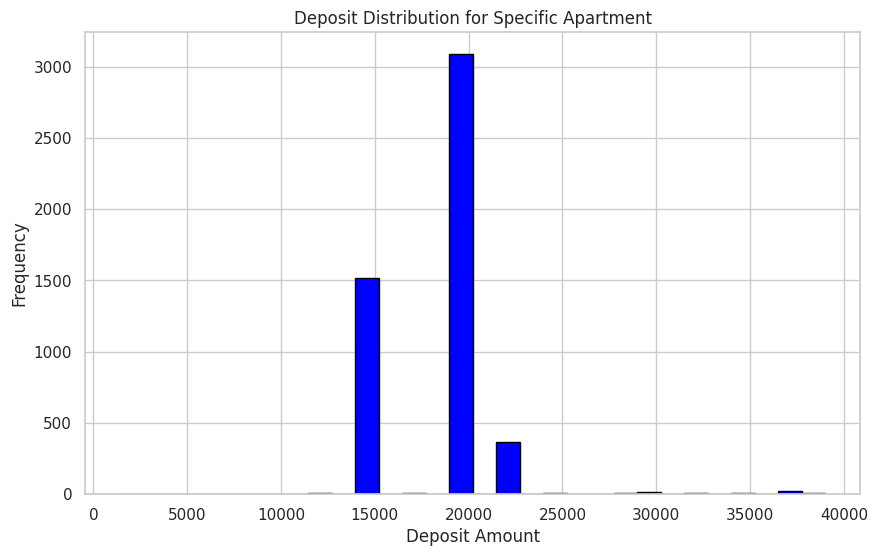

In [ ]:
# Plotting deposit distribution
plt.figure(figsize=(10, 6))
plt.hist(specific_apartment_data['deposit'], bins=30, color='blue', edgecolor='black')
plt.title('Deposit Distribution for Specific Apartment')
plt.xlabel('Deposit Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# 두 번째 빈도 헬리오시티
target_latitude = 37.497618
target_longitude = 127.107260

# np.isclose를 사용하여 근사값 비교로 데이터 필터링
specific_apartment_data = train_data[np.isclose(train_data['latitude'], target_latitude) & np.isclose(train_data['longitude'], target_longitude)]

# 해당 아파트 데이터에 대한 통계량 확인
apartment_statistics = specific_apartment_data.describe(include='all')

# 결과 출력
apartment_statistics

index      area_m2 contract_year_month  contract_day  \
count   3.781000e+03  3781.000000                3781   3781.000000   
unique           NaN          NaN                  57           NaN   
top              NaN          NaN              202302           NaN   
freq             NaN          NaN                 230           NaN   
mean    1.263206e+06    78.044573                 NaN     16.027506   
std     1.601683e+05    20.750229                 NaN      8.436114   
min     1.058471e+06    39.100000                 NaN      1.000000   
25%     1.096126e+06    59.960000                 NaN      9.000000   
50%     1.225807e+06    84.980000                 NaN     16.000000   
75%     1.375908e+06    84.990000                 NaN     23.000000   
max     1.523575e+06   150.090000                 NaN     31.000000   

        contract_type        floor  built_year      latitude     longitude  \
count     3781.000000  3781.000000      3781.0  3.781000e+03  3.781000e+03   
unique            NaN          NaN         NaN           NaN           NaN   
top               NaN          NaN         NaN           NaN           NaN   
freq              NaN          NaN         NaN           NaN           NaN   
mean         1.194922    14.438244      2018.0  3.749762e+01  1.271073e+02   
std          0.883617     8.743899         0.0  1.229402e-12  7.021091e-12   
min          0.000000     1.000000      2018.0  3.749762e+01  1.271073e+02   
25%          0.000000     7.000000      2018.0  3.749762e+01  1.271073e+02   
50%          2.000000    13.000000      2018.0  3.749762e+01  1.271073e+02   
75%          2.000000    21.000000      2018.0  3.749762e+01  1.271073e+02   
max          2.000000    35.000000      2018.0  3.749762e+01  1.271073e+02   

                age        deposit  YYMM  
count   3781.000000    3781.000000  3781  
unique          NaN            NaN    57  
top             NaN            NaN  2302  
freq            NaN            NaN   230  
mean       3.499074   87555.132505   NaN  
std        1.311250   25830.967695   NaN  
min        1.000000    5000.000000   NaN  
25%        3.000000   70000.000000   NaN  
50%        3.000000   84000.000000   NaN  
75%        5.000000  102000.000000   NaN  
max        5.000000  240000.000000   NaN

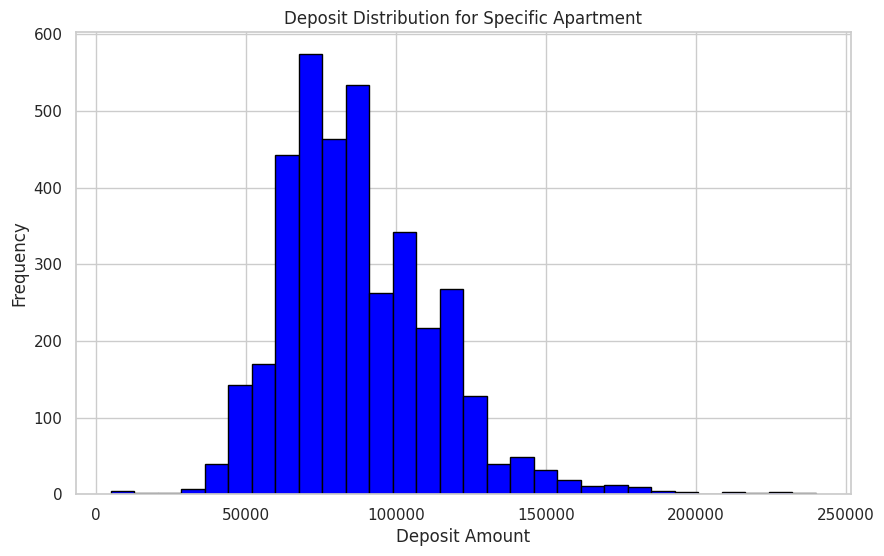

In [ ]:
# Plotting deposit distribution
plt.figure(figsize=(10, 6))
plt.hist(specific_apartment_data['deposit'], bins=30, color='blue', edgecolor='black')
plt.title('Deposit Distribution for Specific Apartment')
plt.xlabel('Deposit Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


최대 빈도 남양주에 위치한 부영 아파트의 거래는 19000에 약 50% 가 차지하고 실제 뉴스 검색 결과 장기전세 정책으로 전세 계약 기록이 많이 차지합니다. 장기전세 는 주변 지역 시세보다 80% 이하로 거래되므로 파악하면 도움이 될 것입니다.

In [ ]:
# 위도와 경도별로 그룹화하고 거래 횟수 계산
grouped_data = train_data.groupby(['latitude', 'longitude']).size().reset_index(name='transaction_count')

# 거래 횟수 통계량 확인
transaction_stats = grouped_data['transaction_count'].describe()

# 결과 출력
transaction_stats



count    18491.000000
mean        97.411065
std        190.146865
min          1.000000
25%          6.000000
50%         26.000000
75%        109.000000
max       5108.000000
Name: transaction_count, dtype: float64

In [ ]:
# 위도와 경도별로 그룹화하여 거래 횟수와 deposit의 고유 값 개수 계산
grouped_data = train_data.groupby(['latitude', 'longitude']).agg(
    transaction_count=('deposit', 'size'),
    unique_deposit_count=('deposit', 'nunique')
).reset_index()

# 거래 횟수가 100 이상이고 deposit의 고유 값이 10 이하인 그룹 필터링
filtered_apartments = grouped_data[
    (grouped_data['transaction_count'] >= 100) &
    (grouped_data['unique_deposit_count'] <= 10)
]

# 결과 출력
filtered_apartments


latitude   longitude  transaction_count  unique_deposit_count
7746   37.491584  126.948370                145                     6
12929  37.551909  127.181488                322                     2
13268  37.556990  127.180734                107                     3
13912  37.570434  127.170025                541                     9
13919  37.570577  127.173350                362                    10
14273  37.577819  126.882814                213                     9
16051  37.620699  127.166239               1013                     4
16277  37.627512  127.148699                706                     4

## 지하철

In [ ]:
# 위도와 경도에서 고유한 값 추출
unique_locations = train_data[['latitude', 'longitude']].drop_duplicates()

# 지도 중심 설정 (고유 위치들의 평균 위도, 경도를 사용)
map_center = [unique_locations['latitude'].mean(), unique_locations['longitude'].mean()]

# folium 지도 생성
m = folium.Map(location=map_center, zoom_start=12)

# MarkerCluster 생성
marker_cluster = MarkerCluster().add_to(m)

# 고유한 위도와 경도에 마커 추가 (MarkerCluster로 그룹화)
for idx, row in unique_locations.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(marker_cluster)

# 지하철 데이터 마커 추가 (지하철 위치 700개 추가)
for idx, row in subway_data.iterrows():
    folium.Marker([row['latitude'], row['longitude']],
                  icon=folium.Icon(color='red', icon='train'),
                  popup="Subway").add_to(m)

# 지도 렌더링
display(m)




In [33]:
# Extract unique latitude and longitude combinations
unique_locations_df = train_data[['latitude', 'longitude']].drop_duplicates()

# Reset the index for the new DataFrame (optional)
unique_locations_df = unique_locations_df.reset_index(drop=True)

# Display the new DataFrame
print(unique_locations_df)


        latitude   longitude
0      37.054314  127.045216
1      36.964647  127.055847
2      36.972390  127.084514
3      36.965423  127.048779
4      36.957089  127.047449
...          ...         ...
18486  37.612604  126.657868
18487  37.584117  126.716550
18488  37.582593  126.716193
18489  37.581261  126.706269
18490  37.590230  126.717255

[18491 rows x 2 columns]


##

지하철 역마다 제일 가까운 역까지의 거리를 재서 역간 거리가 먼 곳의 정보를 활용해 보기 위해 필터링

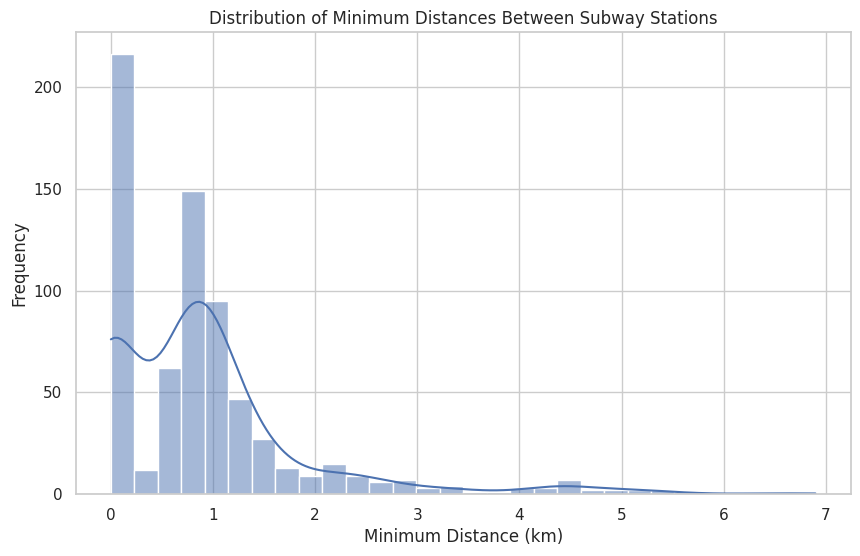

count    700.000000
mean       0.901193
std        1.034896
min        0.000000
25%        0.000000
50%        0.784611
75%        1.104860
max        6.897843
dtype: float64


In [ ]:
# 각 지하철역에서 다른 지하철역까지의 최소 거리를 계산
min_distances = []

for i in range(len(subway_data)):
    current_station = (subway_data.loc[i, 'latitude'], subway_data.loc[i, 'longitude'])
    min_distance = float('inf')  # 초기값으로 매우 큰 값을 설정

    for j in range(len(subway_data)):
        if i != j:  # 자신과의 거리는 계산하지 않음
            other_station = (subway_data.loc[j, 'latitude'], subway_data.loc[j, 'longitude'])
            distance = geodesic(current_station, other_station).kilometers
            if distance < min_distance:
                min_distance = distance

    # 최소 거리를 리스트에 추가
    min_distances.append(min_distance)

# 최소 거리 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(min_distances, bins=30, kde=True)
plt.title('Distribution of Minimum Distances Between Subway Stations')
plt.xlabel('Minimum Distance (km)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 최소 거리 통계량 확인
min_distance_stats = pd.Series(min_distances).describe()

# 통계량 출력
print(min_distance_stats)

지하철 기준으로 클러스터링을 진행합니다. 반경은 1km로 뒀습니다

In [ ]:
# KDTree를 사용하기 위해 위도와 경도를 라디안으로 변환 (지구의 곡률을 고려하기 위함)
train_data_radians = np.radians(train_data[['latitude', 'longitude']])
subway_data_radians = np.radians(subway_data[['latitude', 'longitude']])

# BallTree 생성 (train_data의 위도와 경도를 이용)
tree = BallTree(train_data_radians, metric='haversine')

# 반경 1km(약 0.00157 라디안) 내의 거래 수 계산
radius = 1 / 6371  # 1km를 라디안으로 변환 (지구 반지름: 6371km)

# 결과를 저장할 리스트
subway_transaction_counts = []

# 지하철역마다 1km 반경 내의 거래량 계산
for i in range(len(subway_data)):
    subway_station_radians = subway_data_radians.iloc[i].values.reshape(1, -1)

    # 반경 내에 있는 거래의 인덱스 검색
    indices = tree.query_radius(subway_station_radians, r=radius)

    # 해당 반경 내의 거래 수
    transaction_count = len(indices[0])

    # 지하철역별로 1km 반경 내 거래량을 저장
    subway_transaction_counts.append({
        'subway_latitude': subway_data.loc[i, 'latitude'],
        'subway_longitude': subway_data.loc[i, 'longitude'],
        'transaction_count': transaction_count
    })

# 결과를 데이터프레임으로 변환
subway_transaction_df = pd.DataFrame(subway_transaction_counts)

# 결과 출력
print(subway_transaction_df)

     subway_latitude  subway_longitude  transaction_count
0          37.759380        127.042292               1179
1          37.541021        126.971300               3408
2          37.529849        126.964561               5533
3          37.514219        126.942454               4913
4          37.513342        126.926382               4048
..               ...               ...                ...
695        37.378384        126.645168               3426
696        37.386007        126.639484               4739
697        37.393054        126.634729               5151
698        37.399907        126.630347               2894
699        37.467048        126.707938               2148

[700 rows x 3 columns]


count      700.000000
mean      3829.164286
std       2934.294680
min          0.000000
25%       1340.500000
50%       3445.000000
75%       5511.750000
max      13929.000000
Name: transaction_count, dtype: float64


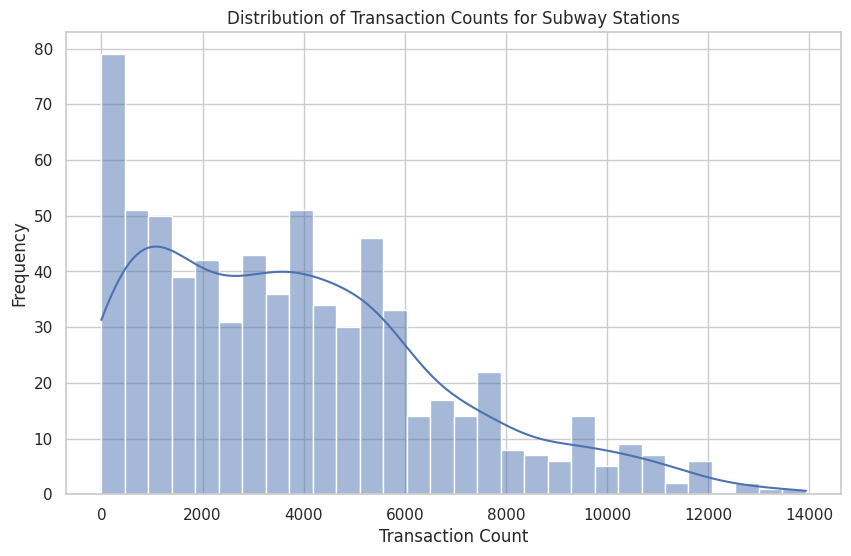

In [ ]:
# 거래량에 대한 통계량 계산
transaction_stats = subway_transaction_df['transaction_count'].describe()

# 거래량 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(subway_transaction_df['transaction_count'], bins=30, kde=True)
plt.title('Distribution of Transaction Counts for Subway Stations')
plt.xlabel('Transaction Count')
plt.ylabel('Frequency')
plt.grid(True)

# 통계량 출력
print(transaction_stats)

# 그래프 출력
plt.show()


In [ ]:
subway_transaction_df[subway_transaction_df['transaction_count'] == 0].shape

(40, 3)

1km 내에 아파트가 없는 역도 40개가 있습니다

### 거리

아파트와 지하철역까지의 거리가 전세가에 영향을 미치는지 확인하기 위해 각 지하철역마다 1km 반경에 있는 아파트들을 필터링해 상관계수를 계산했습니다

In [ ]:
# 위도와 경도를 라디안으로 변환 (지구의 곡률을 고려하기 위함)
train_data_radians = np.radians(train_data[['latitude', 'longitude']])
subway_data_radians = np.radians(subway_data[['latitude', 'longitude']])

# BallTree 생성 (train_data의 위도와 경도를 이용)
tree = BallTree(train_data_radians, metric='haversine')

# 반경 1km(약 0.00157 라디안) 내의 거리 계산
radius = 1 / 6371  # 1km를 라디안으로 변환 (지구 반지름: 6371km)

# 결과를 저장할 리스트
correlation_data = []

# 지하철역마다 1km 반경 내 전세 거래와 거리의 상관계수 계산
for i in range(len(subway_data)):
    subway_station_radians = subway_data_radians.iloc[i].values.reshape(1, -1)
    subway_station_coords = (subway_data.loc[i, 'latitude'], subway_data.loc[i, 'longitude'])

    # 반경 1km 내 아파트 거래 검색
    indices = tree.query_radius(subway_station_radians, r=radius)

    # 반경 1km 내의 아파트 데이터 추출
    nearby_apartments = train_data.iloc[indices[0]]

    if nearby_apartments.empty:
        continue

    # 지하철역과 아파트 간 거리 계산
    distances = nearby_apartments.apply(
        lambda row: geodesic(subway_station_coords, (row['latitude'], row['longitude'])).kilometers, axis=1
    )

    # 거리와 전세 가격(deposit) 간의 상관계수 계산
    if len(nearby_apartments) > 1:
        correlation = distances.corr(nearby_apartments['deposit'])
    else:
        correlation = np.nan  # 데이터가 적으면 상관계수 계산 불가

    # 상관계수를 리스트에 저장
    correlation_data.append({
        'subway_latitude': subway_data.loc[i, 'latitude'],
        'subway_longitude': subway_data.loc[i, 'longitude'],
        'correlation': correlation
    })

# 결과를 데이터프레임으로 변환
correlation_df = pd.DataFrame(correlation_data)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
correlation_df.describe()

subway_latitude  subway_longitude  correlation
count       660.000000        660.000000   658.000000
mean         37.516230        126.967691     0.003119
std           0.122556          0.160887     0.265842
min          36.990726        126.493790    -0.715355
25%          37.476691        126.874347    -0.185854
50%          37.527946        127.001846    -0.000664
75%          37.576846        127.063807     0.197109
max          37.927878        127.628607     0.798314

correlation이 0.4 이상인 역과 -0.4 이하인 역만 필터링 해서 위치를 확인해 일관적인 부분이 있는지 확인합니다

In [ ]:
# 0.4 이상인 역과 -0.4 이하인 역 필터링
high_positive_corr = correlation_df[correlation_df['correlation'] >= 0.4]
high_negative_corr = correlation_df[correlation_df['correlation'] <= -0.4]

# 지도 중심 설정 (데이터의 평균 위도, 경도 사용)
map_center = [correlation_df['subway_latitude'].mean(), correlation_df['subway_longitude'].mean()]

# folium 지도 생성
m = folium.Map(location=map_center, zoom_start=12)

# 0.4 이상인 역 마커 추가 (파란색 마커)
for idx, row in high_positive_corr.iterrows():
    folium.Marker(
        location=[row['subway_latitude'], row['subway_longitude']],
        popup=f"Correlation: {row['correlation']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# -0.4 이하인 역 마커 추가 (빨간색 마커)
for idx, row in high_negative_corr.iterrows():
    folium.Marker(
        location=[row['subway_latitude'], row['subway_longitude']],
        popup=f"Correlation: {row['correlation']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# 지도 저장 (HTML 파일로 저장)
m.save('subway_correlation_map.html')


한 지하철역에서 제일 가까운 지하철 역이 1.2km 이상이면 교통이 불편한 지역이라 판단하고, 따라서 역에서 가까울수록 전세가격에 미치는 영향이 상당할 거라고 판단했습니다.  

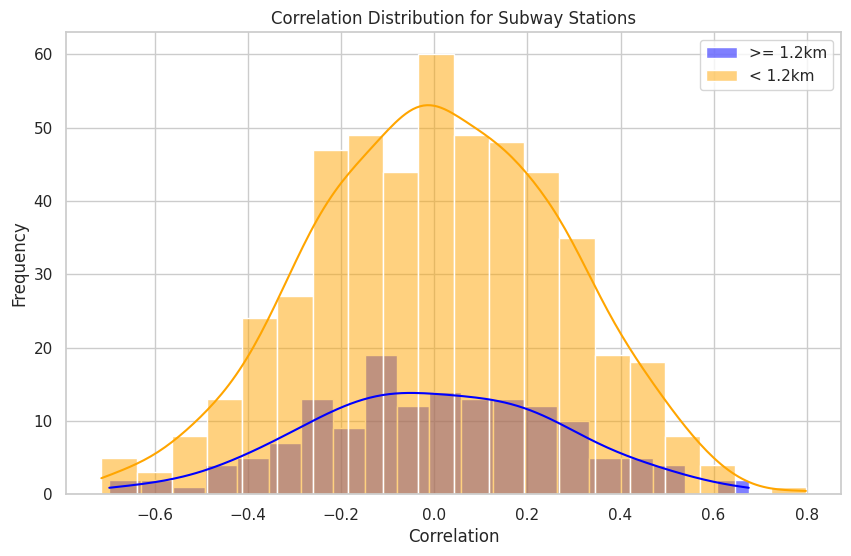

Stations with closest station >= 1.2km:
count    152.000000
mean      -0.001997
std        0.269472
min       -0.698265
25%       -0.195630
50%       -0.007697
75%        0.184687
max        0.675559
Name: correlation, dtype: float64

Stations with closest station < 1.2km:
count    506.000000
mean       0.004656
std        0.264992
min       -0.715355
25%       -0.185456
50%        0.000140
75%        0.197277
max        0.798314
Name: correlation, dtype: float64


In [ ]:
# 위도와 경도를 라디안으로 변환 (지구의 곡률을 고려하기 위함)
subway_data_radians = np.radians(subway_data[['latitude', 'longitude']])

# BallTree 생성 (지하철역 간 거리 계산을 위해)
subway_tree = BallTree(subway_data_radians, metric='haversine')

# 결과를 저장할 리스트
distance_groups = []

# 지하철역 간 거리 계산 및 1.2km 이상, 미만으로 그룹화
for i in range(len(correlation_df)):  # 거래가 있는 지하철역만 대상으로 처리
    subway_station_radians = subway_data_radians.iloc[i].values.reshape(1, -1)

    # 가장 가까운 두 지하철역 검색 (자신 포함)
    distances, indices = subway_tree.query(subway_station_radians, k=2)

    # 가장 가까운 다른 지하철역까지의 거리 계산
    closest_distance = distances[0][1] * 6371  # 라디안 -> km 변환

    # 1.2km 이상인 경우와 미만인 경우를 나누어 저장
    if closest_distance >= 1.2:
        distance_groups.append('>= 1.2km')
    else:
        distance_groups.append('< 1.2km')

# 거래가 있는 지하철역에 대해서만 그룹화된 데이터를 correlation_df에 추가
correlation_df['distance_group'] = distance_groups

# 1.2km 이상과 미만 그룹의 상관관계 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(correlation_df[correlation_df['distance_group'] == '>= 1.2km']['correlation'], color='blue', label='>= 1.2km', kde=True, bins=20)
sns.histplot(correlation_df[correlation_df['distance_group'] == '< 1.2km']['correlation'], color='orange', label='< 1.2km', kde=True, bins=20)
plt.title('Correlation Distribution for Subway Stations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# 각 그룹의 통계량 출력
print("Stations with closest station >= 1.2km:")
print(correlation_df[correlation_df['distance_group'] == '>= 1.2km']['correlation'].describe())

print("\nStations with closest station < 1.2km:")
print(correlation_df[correlation_df['distance_group'] == '< 1.2km']['correlation'].describe())


확인 결과, 1.2 km 이상인 곳에서 correlation이 0에 근사하는 비율이 상당히 낮아지긴 했으나 영향에 대한 정확한 평가가 어려움을 알 수 있습니다. 특히나 정규분포를 형성하고 있어 다른 변인 요소를 제외했는지 확인할 필요가 있습니다. 추측으로는 건물의 나이, 건물의 면적 등이 추가적으로 고려되서 들어가야 됩니다

## 학교

학교의 경우 데이터가 10000개가 넘기도 하고 행정적으로 주변 거주 인구를 고려하고 최대 통학 거리 및 시간을 고려하기 때문에 분석에 용이합니다.

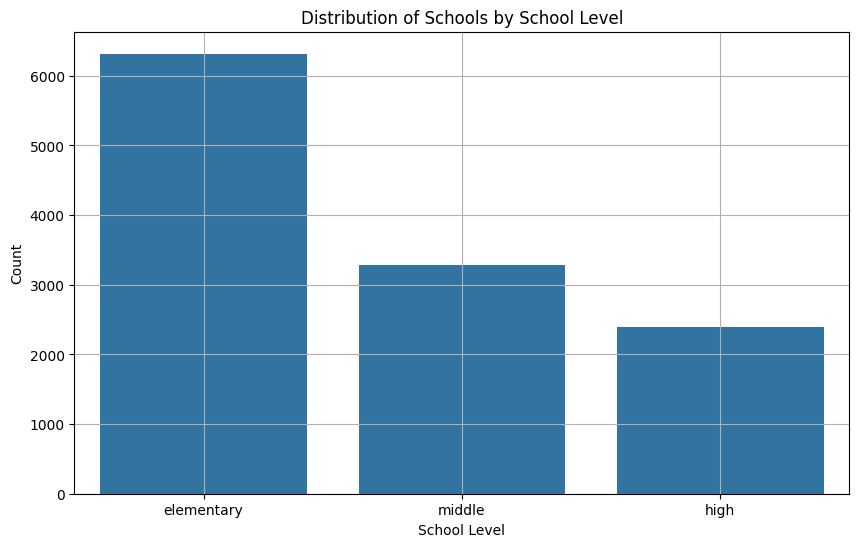

In [26]:
# schoolLevel별 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='schoolLevel', data=school_data)
plt.title('Distribution of Schools by School Level')
plt.xlabel('School Level')
plt.ylabel('Count')
plt.grid(True)
plt.show()

데이터가 전국의 학교를 포함하기 때문에 모든 아파트에서 거리가 2km 이상인 학교는 제외

In [27]:
# 위도와 경도를 라디안으로 변환 (지구의 곡률을 고려하기 위함)
train_data_radians = np.radians(train_data[['latitude', 'longitude']])
school_data_radians = np.radians(school_data[['latitude', 'longitude']])

# BallTree 생성 (train_data의 위도와 경도를 이용)
tree = BallTree(train_data_radians, metric='haversine')

# 반경 2km(약 0.00314 라디안) 내의 거리 계산
radius = 2 / 6371  # 2km를 라디안으로 변환 (지구 반지름: 6371km)

# 결과를 저장할 리스트
filtered_schools = []

# 각 학교마다 2km 이내 아파트가 있는지 확인
for i in range(len(school_data)):
    school_coords_radians = school_data_radians.iloc[i].values.reshape(1, -1)
    school_coords = (school_data.loc[i, 'latitude'], school_data.loc[i, 'longitude'])

    # 반경 2km 내 아파트 거래 검색
    indices = tree.query_radius(school_coords_radians, r=radius)

    # 2km 이내에 아파트가 있으면 해당 학교를 저장
    if len(indices[0]) > 0:
        filtered_schools.append(school_data.iloc[i])

# 필터링된 학교 데이터프레임 생성
filtered_schools_df = pd.DataFrame(filtered_schools)

# 지도 중심 설정 (필터링된 학교들의 평균 위도, 경도 사용)
map_center = [filtered_schools_df['latitude'].mean(), filtered_schools_df['longitude'].mean()]

# folium 지도 생성
m = folium.Map(location=map_center, zoom_start=12)

# 마커 색상을 schoolLevel에 따라 다르게 설정
color_dict = {
    'elementary': 'blue',
    'middle': 'green',
    'high': 'red'
}

# 필터링된 schoolLevel별로 지도에 마커 추가
for idx, row in filtered_schools_df.iterrows():
    school_level = row['schoolLevel']
    color = color_dict.get(school_level, 'gray')  # 미지정된 schoolLevel은 회색으로 표시
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"School Level: {school_level}",
        icon=folium.Icon(color=color)
    ).add_to(m)

# 지도 저장 (HTML 파일로 저장)

m.save('filtered_schools_map.html')

In [28]:
filtered_schools_df

schoolLevel   latitude   longitude
5          middle  37.486153  127.056121
7            high  37.395716  126.909033
8            high  37.559989  126.853133
18           high  37.001940  127.172359
24     elementary  37.500615  126.924883
...           ...        ...         ...
11977  elementary  37.477130  127.149414
11978        high  37.847992  126.881304
11982        high  37.534932  127.227443
11984  elementary  37.309024  127.089889
11989  elementary  37.493705  126.900119

[4060 rows x 3 columns]

### 반경 0.6km

동네를 생각해본다면 학교에서 반경 0.6km 이하일 경우, 같은 동네라 생각하고 반경 0.6km 기준으로 시작했습니다

In [29]:
# 반경 0.6km (약 0.0000942 라디안) 내의 거리 계산
radius_0_6km = 0.6 / 6371  # 0.6km를 라디안으로 변환 (지구 반지름: 6371km)

# 리스트로 각 학교 근처 0.6km 내 아파트 수를 저장
apartments_within_radius = []

# 각 필터링된 학교에 대해 0.6km 이내 아파트 수를 확인
for i in range(len(filtered_schools_df)):
    school_coords_radians = np.radians(filtered_schools_df[['latitude', 'longitude']].iloc[i].values.reshape(1, -1))

    # 반경 0.6km 내 아파트 검색
    indices = tree.query_radius(school_coords_radians, r=radius_0_6km)

    # 해당 학교 근처 0.6km 내 아파트 수를 저장
    num_apartments = len(indices[0])
    apartments_within_radius.append(num_apartments)

# 결과를 새로운 컬럼에 추가
filtered_schools_df['apartments_within_0_6km'] = apartments_within_radius

# 결과 출력
print(filtered_schools_df[['schoolLevel', 'latitude', 'longitude', 'apartments_within_0_6km']])


      schoolLevel   latitude   longitude  apartments_within_0_6km
5          middle  37.486153  127.056121                     2492
7            high  37.395716  126.909033                      981
8            high  37.559989  126.853133                     2572
18           high  37.001940  127.172359                     1407
24     elementary  37.500615  126.924883                      604
...           ...        ...         ...                      ...
11977  elementary  37.477130  127.149414                     3512
11978        high  37.847992  126.881304                        0
11982        high  37.534932  127.227443                     1021
11984  elementary  37.309024  127.089889                     3176
11989  elementary  37.493705  126.900119                     1116

[4060 rows x 4 columns]


In [30]:
filtered_schools_df[filtered_schools_df['apartments_within_0_6km'] == 0]

schoolLevel   latitude   longitude  apartments_within_0_6km
29     elementary  37.116316  127.645391                        0
130        middle  37.126489  127.617090                        0
142        middle  37.303742  127.330793                        0
224    elementary  37.462471  127.130384                        0
267          high  37.583788  126.987473                        0
...           ...        ...         ...                      ...
11673        high  37.758832  127.019645                        0
11802  elementary  37.239018  127.116489                        0
11960        high  37.468636  126.601666                        0
11961  elementary  37.167822  126.984152                        0
11978        high  37.847992  126.881304                        0

[169 rows x 4 columns]

반경 0.6km 로 필터링 한 결과 반경에 아파트 거래가 존재하지 않은 학교도 169개가 발견되었습니다.

아파트가 없는 학교 시각화

In [31]:
import folium

# 필터링된 schools (반경 0.6km 내 아파트가 없는 학교들)
schools_with_no_apartments = filtered_schools_df[filtered_schools_df['apartments_within_0_6km'] == 0]

# 가장 가까운 아파트와 거리를 저장할 리스트
nearest_apartments = []
distances = []

# 각 학교에 대해 가장 가까운 아파트 찾기
for i in range(len(schools_with_no_apartments)):
    school_coords_radians = np.radians(schools_with_no_apartments[['latitude', 'longitude']].iloc[i].values.reshape(1, -1))

    # 가장 가까운 아파트의 인덱스와 거리 찾기 (k=1 이므로 가장 가까운 1개 아파트를 찾음)
    dist, ind = tree.query(school_coords_radians, k=1)

    # 아파트의 인덱스를 이용해 아파트 위치 가져오기
    nearest_apartment_index = ind[0][0]
    nearest_apartment = train_data.iloc[nearest_apartment_index]

    # 가장 가까운 아파트 정보와 거리를 저장
    nearest_apartments.append(nearest_apartment)
    distances.append(dist[0][0])  # 거리 저장 (라디안)

# DataFrame으로 변환
nearest_apartments_df = pd.DataFrame(nearest_apartments)
nearest_apartments_df['distance_km'] = np.array(distances) * 6371  # 거리를 km로 변환

# 지도 중심 설정 (학교들의 평균 위도, 경도 사용)
map_center = [schools_with_no_apartments['latitude'].mean(), schools_with_no_apartments['longitude'].mean()]

# folium 지도 생성
m = folium.Map(location=map_center, zoom_start=12)

# 학교 마커 추가 (0.6km 내에 아파트가 없는 학교)
for idx, row in schools_with_no_apartments.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"School with No Apartments within 0.6km: {row['schoolLevel']}",
        icon=folium.Icon(color='red')
    ).add_to(m)

# 가장 가까운 아파트 마커 추가
for idx, row in nearest_apartments_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Nearest Apartment, Distance: {row['distance_km']:.2f} km",  # 거리 (km로 변환)
        icon=folium.Icon(color='blue')
    ).add_to(m)

# 지도 저장 (HTML 파일로 저장)
m.save('schools_with_no_apartments_map.html')


학교마다 600m 내에 있는 리스트 정리하고 600m 이상인 아파트들은 가장 가까운 학교에 리스트로 추가합니다

In [34]:
# 1. Convert latitude/longitude to radians for the BallTree calculation
train_data_radians = np.radians(filtered_schools_df[['latitude', 'longitude']])
unique_locations_radians = np.radians(unique_locations_df[['latitude', 'longitude']])

# 2. Create a BallTree for the school's coordinates using haversine metric
tree = BallTree(train_data_radians, metric='haversine')

# 3. Define 600 meters in radians (earth radius ~6371 km)
radius_600m = 0.6 / 6371.0  # converting 600 meters to radians

# 4. Query the BallTree to find all unique apartments within 600m of any school
# We use query_radius to get all points within 0.6 km of each school
indices_within_600m = tree.query_radius(unique_locations_radians, r=radius_600m)

# Create a set to store unique lat/lon pairs within 600m of any school
apartments_within_600m = set()

# Iterate over results to collect unique apartments within 600m
for idx_list in indices_within_600m:
    for idx in idx_list:
        apartments_within_600m.add((unique_locations_df.iloc[idx]['latitude'], unique_locations_df.iloc[idx]['longitude']))

# Convert the set back to a DataFrame for easy use later
apartments_within_600m_df = pd.DataFrame(apartments_within_600m, columns=['latitude', 'longitude'])

# 5. Find apartments beyond 600 meters
# Identify apartments that are not in the 600m radius list
unique_apartments_set = set(zip(unique_locations_df['latitude'], unique_locations_df['longitude']))
apartments_beyond_600m = unique_apartments_set - apartments_within_600m

# 6. For each apartment beyond 600 meters, find the nearest school using BallTree
apartments_beyond_600m_list = list(apartments_beyond_600m)
apartments_beyond_600m_radians = np.radians(apartments_beyond_600m_list)

# Query nearest school for each apartment beyond 600 meters
distances_beyond_600m, indices_beyond_600m = tree.query(apartments_beyond_600m_radians, k=1)

# Prepare a DataFrame to store these apartments and their closest school
closest_schools_for_beyond_600m = pd.DataFrame({
    'latitude': [lat for lat, lon in apartments_beyond_600m_list],
    'longitude': [lon for lat, lon in apartments_beyond_600m_list],
    'closest_school_index': indices_beyond_600m.flatten(),
    'distance_km': distances_beyond_600m.flatten() * 6371  # convert radians to kilometers
})

# 7. Combine all apartments (within 600m and beyond) into one result DataFrame
final_apartments_df = pd.concat([apartments_within_600m_df, closest_schools_for_beyond_600m])





위의 eda 에서 알 수 있듯이 보통 60 제곱미터에서 100 제곱미터 사이에 아파트들이 많습니다. 이 area 에 위치한 아파트들이 지역의 평균 전세가를 잘 반영한다고 생각하여 필터링하고 학교별로 구역을 나눈뒤에 통계량을 분석합니다(건물의 나이, deposit per m2, std of deposit per m2 등)

In [39]:
# 2. Filter apartments with area between 60 and 85 square meters
filtered_apartments = train_data[(train_data['area_m2'] >= 60) & (train_data['area_m2'] <= 100)]

# 3. Convert latitude/longitude to radians for BallTree calculation
school_coords_radians = np.radians(filtered_schools_df[['latitude', 'longitude']])
apartment_coords_radians = np.radians(filtered_apartments[['latitude', 'longitude']])

# 4. Create a BallTree for the school's coordinates
tree = BallTree(apartment_coords_radians, metric='haversine')

# Define 600 meters in radians (earth radius ~6371 km)
radius_600m = 0.6 / 6371.0

# 5. Query the BallTree to find apartments within 600 meters of each school
apartments_within_radius = tree.query_radius(school_coords_radians, r=radius_600m)
# 6. Calculate the mean, standard deviation for deposit_per_m2 and age for each school
school_stats = []

for i, indices in enumerate(apartments_within_radius):
    if len(indices) > 0:
        # Get the apartments for this school within 600 meters
        nearby_apartments = filtered_apartments.iloc[indices]

        # Calculate mean and std for deposit_per_m2 and age
        mean_price_per_m2 = nearby_apartments['deposit_per_m2'].mean()
        std_price_per_m2 = nearby_apartments['deposit_per_m2'].std()
        mean_age = nearby_apartments['age'].mean()
        std_age = nearby_apartments['age'].std()

        # Append the results for the current school
        school_stats.append({
            'school_latitude': filtered_schools_df.iloc[i]['latitude'],
            'school_longitude': filtered_schools_df.iloc[i]['longitude'],
            'mean_price_per_m2': mean_price_per_m2,
            'std_price_per_m2': std_price_per_m2,
            'mean_age': mean_age,
            'std_age': std_age,
            'num_transactions': len(nearby_apartments)
        })
    else:
        # No apartments found within 600m for this school
        school_stats.append({
            'school_latitude': filtered_schools_df.iloc[i]['latitude'],
            'school_longitude': filtered_schools_df.iloc[i]['longitude'],
            'mean_price_per_m2': np.nan,
            'std_price_per_m2': np.nan,
            'mean_age': np.nan,
            'std_age': np.nan,
            'num_transactions': 0
        })

# 7. Convert the results to a DataFrame
school_stats_df = pd.DataFrame(school_stats)

# Display the result
print(school_stats_df)


      school_latitude  school_longitude  mean_price_per_m2  std_price_per_m2  \
0           37.486153        127.056121         988.495768        292.276761   
1           37.395716        126.909033         329.641732         68.164764   
2           37.559989        126.853133         529.952949         91.407186   
3           37.001940        127.172359         266.090971         75.741249   
4           37.500615        126.924883         673.050602        249.102016   
...               ...               ...                ...               ...   
4055        37.477130        127.149414         700.603600        125.698028   
4056        37.847992        126.881304                NaN               NaN   
4057        37.534932        127.227443         450.365146        111.795258   
4058        37.309024        127.089889         454.832347        110.702278   
4059        37.493705        126.900119         470.010624        104.168064   

       mean_age    std_age  num_transac

구역으로 나눈 아파트 거래 통계량입니다

In [40]:
school_stats_df.describe()

school_latitude  school_longitude  mean_price_per_m2  std_price_per_m2  \
count      4060.000000       4060.000000        3839.000000       3827.000000   
mean         37.477785        126.963664         456.951581        110.769132   
std           0.180730          0.186322         204.934098         64.397041   
min          36.946463        126.472799          30.022817          0.000000   
25%          37.368908        126.823377         319.251315         73.122254   
50%          37.498241        126.980111         415.722475         97.878230   
75%          37.592298        127.087002         552.276521        128.682251   
max          38.183017        127.647899        1706.487823        649.163337   

          mean_age      std_age  num_transactions  
count  3839.000000  3827.000000       4060.000000  
mean     17.096638     5.625574        681.894089  
std       8.216813     3.685795        652.289530  
min      -2.000000     0.000000          0.000000  
25%      11.257314     2.178607        187.750000  
50%      17.233288     5.272359        510.000000  
75%      23.338994     8.189775        989.250000  
max      47.859784    20.569364       6261.000000

In [41]:
school_stats_df[school_stats_df['std_price_per_m2'] > 500]

school_latitude  school_longitude  mean_price_per_m2  std_price_per_m2  \
19          37.501996        126.994230        1417.766004        649.163337   
109         37.539452        127.051384         877.812055        553.811622   
544         37.540942        127.046605         969.506781        597.353602   
616         37.501996        126.994230        1417.766004        649.163337   
1250        37.506265        126.996115        1257.086839        626.846865   
1338        37.501859        126.998097        1353.434843        525.261450   
1391        37.547342        127.038253         795.065346        552.951375   
2101        37.501983        126.994230        1417.766004        649.163337   
2602        37.547342        127.038253         795.065346        552.951375   
3362        37.510312        127.004054        1107.792686        528.789441   

       mean_age    std_age  num_transactions  
19    17.430918  14.554301              1035  
109   20.355412   8.175798              1238  
544   20.262687  10.107916              1005  
616   17.430918  14.554301              1035  
1250  23.069781  17.888439              1777  
1338  18.018564  10.109973               808  
1391  29.000000   7.851751                81  
2101  17.430918  14.554301              1035  
2602  29.000000   7.851751                81  
3362  23.852512  16.823656              2468

구역 내 std_price_per_m2가 높은 구역만 뽑았더니 mean price per m2 가 높기도 했지만 age의 std 도 높았습니다. 나올 수 있는 가설로는 따라서 age와 mean price 가 구역 내 일관적인 가격형성을 방해한다 볼 수 있습니다

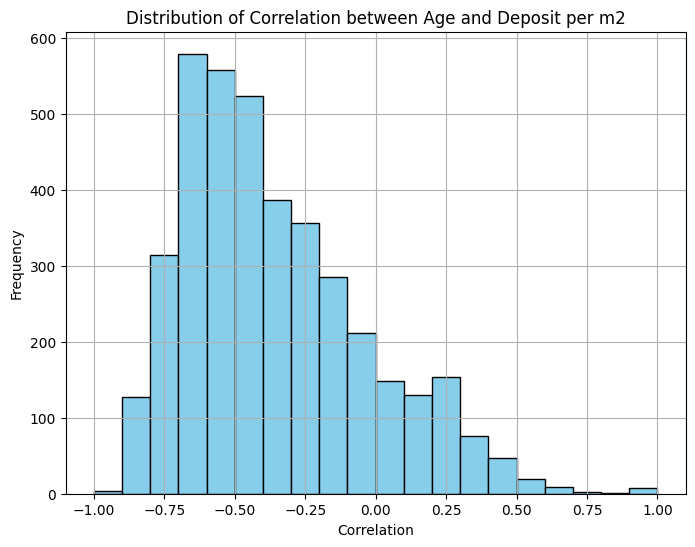

      school_latitude  school_longitude  num_transactions  correlation
0           37.486153        127.056121              3797    -0.599105
1           37.395716        126.909033              1123    -0.561713
2           37.559989        126.853133              2472    -0.271495
3           37.001940        127.172359              1106    -0.345334
4           37.500615        126.924883              1862    -0.438150
...               ...               ...               ...          ...
4055        37.477130        127.149414              4341     0.212468
4056        37.847992        126.881304                 0          NaN
4057        37.534932        127.227443              1226    -0.145739
4058        37.309024        127.089889              4870    -0.519105
4059        37.493705        126.900119              2381    -0.631089

[4060 rows x 4 columns]


In [48]:
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt

# 1. Filter apartments with area between 60 and 100 square meters
filtered_apartments = train_data[(train_data['area_m2'] >= 60) & (train_data['area_m2'] <= 100)]

# 2. Convert latitude/longitude to radians for BallTree calculation
school_coords_radians = np.radians(filtered_schools_df[['latitude', 'longitude']])
apartment_coords_radians = np.radians(filtered_apartments[['latitude', 'longitude']])

# 3. Create a BallTree for the apartment coordinates
tree = BallTree(apartment_coords_radians, metric='haversine')

# Define 600 meters in radians (earth radius ~6371 km)
radius_600m = 1 / 6371.0

# 4. Query the BallTree to find apartments within 600 meters of each school
apartments_within_radius = tree.query_radius(school_coords_radians, r=radius_600m)

# 5. Calculate the correlation between age and deposit_per_m2 for each school
correlation_results = []

for i, indices in enumerate(apartments_within_radius):
    # Check if there are apartments within 600m for this school
    if len(indices) > 1:  # At least 2 transactions needed for correlation
        # Get the apartments for this school within 600 meters
        nearby_apartments = filtered_apartments.iloc[indices]

        # Calculate correlation between 'age' and 'deposit_per_m2'
        correlation = nearby_apartments[['age', 'deposit_per_m2']].corr().loc['age', 'deposit_per_m2']

        # Store the result
        correlation_results.append({
            'school_latitude': filtered_schools_df.iloc[i]['latitude'],
            'school_longitude': filtered_schools_df.iloc[i]['longitude'],
            'correlation': correlation,
            'num_transactions': len(nearby_apartments)
        })
    else:
        # Not enough data for correlation calculation
        correlation_results.append({
            'school_latitude': filtered_schools_df.iloc[i]['latitude'],
            'school_longitude': filtered_schools_df.iloc[i]['longitude'],
            'correlation': np.nan,
            'num_transactions': len(indices)
        })

# 6. Convert the results to a DataFrame
correlation_df = pd.DataFrame(correlation_results)

# 7. Filter out NaN correlations
valid_correlations = correlation_df['correlation'].dropna()

# 8. Plot the distribution of correlations
plt.figure(figsize=(8, 6))
plt.hist(valid_correlations, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Correlation between Age and Deposit per m2')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display the correlation DataFrame
print(correlation_df[['school_latitude', 'school_longitude', 'num_transactions', 'correlation']])


600m 로 했을 때 age와 deposit per m2 의 상관관계가 0에 가까웠으나 범위를 800m, 1km로 점차 늘렸을 때 correlation 이 전체적으로 왼쪽으로 distribution 이 형성되는 것을 봤고 이러한 현상에 대한 이유로는 아무래도 샘플의 수가 많아지면서 좀 더 정확한 상관관계가 형성된다고 생각합니다

In [49]:
correlation_df.describe()

school_latitude  school_longitude  correlation  num_transactions
count      4060.000000       4060.000000  3935.000000       4060.000000
mean         37.477785        126.963664    -0.357428       1586.063054
std           0.180730          0.186322     0.324500       1270.299888
min          36.946463        126.472799    -1.000000          0.000000
25%          37.368908        126.823377    -0.605576        613.250000
50%          37.498241        126.980111    -0.429527       1308.500000
75%          37.592298        127.087002    -0.167378       2272.000000
max          38.183017        127.647899     1.000000      10170.000000

In [47]:
correlation_df[correlation_df['correlation'] > 0.5]

school_latitude  school_longitude  correlation  num_transactions
219         37.372478        127.248386     0.525565                97
230         37.831315        126.829902     0.572221                40
301         37.480728        126.920957     0.626004               131
342         37.535392        126.887734     0.542140              2548
538         37.041840        127.127739     0.500604                63
579         37.296794        127.620956     1.000000                 2
607         37.265631        127.085175     0.509538               457
622         37.589170        126.971096     0.931808                 5
813         37.461528        127.137279     0.656010              1299
848         37.348881        127.166665     0.568277                82
920         37.681937        127.493950     0.594017                21
969         37.201624        126.981323     0.510855                38
1029        37.191356        127.060268     0.575987               837
1119        37.465765        127.147019     0.519481              2685
1202        37.474165        127.031886     0.613149               772
1232        37.589259        126.970057     0.931808                 5
1360        37.042288        127.087090     0.570256                89
1453        37.343194        127.173826     0.548368                59
1482        37.681937        127.493938     0.594017                21
1486        38.000044        127.245809     0.938354                 5
1554        37.960633        127.314420     0.642482                10
1562        38.089865        127.275879     1.000000                 2
1647        37.298516        127.572737     0.556589                27
1685        38.007003        127.246080     0.938354                 5
1714        37.482136        126.921037     0.559480               148
1737        37.186564        127.071940     0.608194               287
1930        37.831049        126.834860     0.572221                40
1993        38.093640        127.277657     1.000000                 2
2005        37.301589        127.093785     0.542036               732
2022        37.662391        127.347301     0.602239               865
2037        37.673814        126.744477     0.543561               680
2060        37.776412        126.738651     0.517816                99
2231        37.796446        126.986664     0.506727                15
2589        37.205000        126.775205     1.000000                 2
2609        37.271925        127.208493     0.665490                30
2668        36.994028        126.841645     0.658740                98
2789        37.532871        126.885696     0.566216              1645
2918        37.256294        127.081293     0.621561               849
3111        37.340141        126.845785     0.652883                 9
3184        37.142264        127.090924     0.617056               141
3220        37.833044        126.829696     0.572221                40
3433        36.988926        126.848074     0.641851               183
3621        37.679525        127.490736     0.594017                21
3623        36.965255        126.921943     0.892630                 9
3678        37.535384        126.887734     0.542140              2548
3750        37.255471        127.081656     0.621561               849
3759        37.480728        126.920957     0.626004               131
3884        37.204184        126.772663     1.000000                 2
3922        36.989221        126.848762     0.641851               183

상관관계가 0.5 이상인 학교들을 필터링 했을 때 거래량이 많지 않은 곳이 대다수라 샘플의 수에 correlation 이 정확히 나오지 않음을 추측 가능하며 샘플 수가 많은 곳에 대해서는 추가적인 조사가 필요합니다. 따라서, 상위 두 곳인 목동과 위례에 대해 추가적인 조사를 진행했습니다

### 목동

In [71]:
import numpy as np
from sklearn.neighbors import BallTree

# 주어진 중심 좌표 (위도, 경도) -> 라디안으로 변환
center_coord = np.radians([[37.535392, 126.887734]])

# Convert apartment coordinates to radians from train_data
apartment_coords_radians = np.radians(train_data[['latitude', 'longitude']])

# Create a BallTree for the apartment coordinates
tree = BallTree(apartment_coords_radians, metric='haversine')

# Define 800 meters in radians (earth radius ~6371 km)
radius_800m = 0.8 / 6371.0

# Query the BallTree to find apartments within 800 meters of the center point
apartments_within_radius = tree.query_radius(center_coord, r=radius_800m)

# Extract the apartments found within the radius from train_data
nearby_apartments = train_data.iloc[apartments_within_radius[0]]

# Display the extracted apartments
print(nearby_apartments)


           index  area_m2  contract_year_month  contract_day  contract_type  \
1002836  1002836    95.01               201904             5              2   
1002862  1002862   122.46               201904            11              2   
1002844  1002844    93.24               201904             6              2   
1002874  1002874   143.36               201904            13              2   
1002898  1002898    65.08               201904            19              2   
...          ...      ...                  ...           ...            ...   
1569505  1569505    70.94               202307            27              0   
1026545  1026545    81.18               202001            10              2   
1574617  1574617    70.94               202311             4              0   
1577266  1577266    59.84               202312            26              1   
1440360  1440360    70.94               202211            18              0   

         floor  built_year   latitude   longitude  

In [52]:
nearby_apartments['built_year'].value_counts()

built_year
1986    1843
1985    1057
2000     606
1996     601
1999     209
1993     103
1998      78
1991      48
2009      27
2003      18
2012      10
Name: count, dtype: int64

built_year 중심으로 count 했을 때 1986년과 1985년, 2000년 을 기준으로 본다면 문제의 원인을 파악할 수 있을 거라 예상됩니다

In [79]:
nearby_apartments[nearby_apartments['built_year'] == 2000].describe()

index     area_m2  contract_year_month  contract_day  \
count  6.060000e+02  606.000000           606.000000    606.000000   
mean   1.299332e+06   84.676667        202129.128713     15.853135   
std    1.921222e+05   33.460722           133.452316      8.798378   
min    1.003149e+06   59.840000        201904.000000      1.000000   
25%    1.135055e+06   59.980000        202007.000000      8.000000   
50%    1.292308e+06   79.690000        202111.000000     16.000000   
75%    1.485101e+06   84.940000        202211.000000     23.000000   
max    1.618752e+06  238.310000        202312.000000     31.000000   

       contract_type       floor  built_year    latitude   longitude  \
count     606.000000  606.000000       606.0  606.000000  606.000000   
mean        1.196370   11.117162      2000.0   37.534585  126.891634   
std         0.873515    6.344736         0.0    0.002296    0.005342   
min         0.000000    1.000000      2000.0   37.531957  126.881106   
25%         0.000000    6.000000      2000.0   37.531957  126.893591   
50%         1.000000   11.000000      2000.0   37.535867  126.893820   
75%         2.000000   16.750000      2000.0   37.536726  126.893820   
max         2.000000   25.000000      2000.0   37.537104  126.896608   

              age        deposit  deposit_per_m2  
count  606.000000     606.000000      606.000000  
mean    21.226073   57267.958746      675.537045  
std      1.338575   27205.718144      145.374262  
min     19.000000   10000.000000       62.656642  
25%     20.000000   40000.000000      577.248379  
50%     21.000000   47250.000000      644.025317  
75%     22.000000   60000.000000      763.520862  
max     23.000000  170000.000000     1217.216715

In [80]:
nearby_apartments[nearby_apartments['built_year'] == 1986].describe()

index      area_m2  contract_year_month  contract_day  \
count  1.843000e+03  1843.000000          1843.000000   1843.000000   
mean   1.267448e+06    76.900781        202117.844818     16.073793   
std    2.002242e+05    27.360132           140.945457      8.672969   
min    1.002819e+06    47.940000        201904.000000      1.000000   
25%    1.083597e+06    47.940000        202006.000000      9.000000   
50%    1.228598e+06    65.100000        202109.000000     16.000000   
75%    1.471354e+06    95.060000        202211.000000     24.000000   
max    1.604641e+06   152.850000        202312.000000     31.000000   

       contract_type        floor  built_year     latitude    longitude  \
count    1843.000000  1843.000000      1843.0  1843.000000  1843.000000   
mean        1.291915     7.836679      1986.0    37.534496   126.882732   
std         0.821452     5.109116         0.0     0.000551     0.002285   
min         0.000000     1.000000      1986.0    37.533961   126.880515   
25%         1.000000     3.500000      1986.0    37.533961   126.880515   
50%         2.000000     7.000000      1986.0    37.533961   126.880515   
75%         2.000000    12.000000      1986.0    37.535063   126.885085   
max         2.000000    20.000000      1986.0    37.535063   126.885085   

               age        deposit  deposit_per_m2  
count  1843.000000    1843.000000     1843.000000  
mean     35.107434   62845.876831      809.538898  
std       1.413201   26434.051359      166.384320  
min      33.000000    4700.000000       72.218808  
25%      34.000000   42000.000000      696.095970  
50%      35.000000   57700.000000      774.193548  
75%      36.000000   80000.000000      894.548526  
max      37.000000  160000.000000     1536.570375

In [78]:
nearby_apartments[nearby_apartments['built_year'] == 1986][['latitude','longitude']].drop_duplicates()


latitude   longitude
1002836  37.533961  126.880515
1002849  37.535063  126.885085

In [77]:
nearby_apartments[nearby_apartments['built_year'] == 2000][['latitude','longitude']].drop_duplicates()


latitude   longitude
1003266  37.536391  126.881106
1003281  37.536726  126.882214
1026507  37.537104  126.893591
1026474  37.531957  126.893820
1026504  37.535867  126.896608

확인 결과, 대단지와 소단지의 차이가 유의미한 것으로 보입니다

### 위례

In [58]:

# 주어진 중심 좌표 (위도, 경도) -> 라디안으로 변환
center_coord = np.radians([[37.465765,	127.147019]])

# Convert apartment coordinates to radians from train_data
apartment_coords_radians = np.radians(train_data[['latitude', 'longitude']])

# Create a BallTree for the apartment coordinates
tree = BallTree(apartment_coords_radians, metric='haversine')

# Define 800 meters in radians (earth radius ~6371 km)
radius_800m = 0.8 / 6371.0

# Query the BallTree to find apartments within 800 meters of the center point
apartments_within_radius = tree.query_radius(center_coord, r=radius_800m)

# Extract the apartments found within the radius from train_data
nearby_apartments = train_data.iloc[apartments_within_radius[0]]

# Display the extracted apartments
print(nearby_apartments)


         index   area_m2  contract_year_month  contract_day  contract_type  \
90951    90951  134.2637               201904             1              2   
90945    90945  134.2637               201904             1              2   
90946    90946  134.3577               201904             1              2   
90947    90947   85.9695               201904             1              2   
90948    90948  134.2637               201904             1              2   
...        ...       ...                  ...           ...            ...   
874421  874421  101.9650               202312            27              1   
874416  874416  101.5982               202311            21              0   
874417  874417  101.9650               202311            25              0   
874420  874420  101.9650               202312            26              0   
874419  874419  101.9650               202312            26              0   

        floor  built_year   latitude   longitude  age  deposit 

In [59]:
nearby_apartments['built_year'].value_counts()

built_year
2019    1311
2016    1099
2015    1009
2017     401
Name: count, dtype: int64

빈도 수로 볼 때 2019년과 2016,2015를 중점으로 보면 됩니다

In [60]:
nearby_apartments[nearby_apartments['built_year'] == 2019].mean()

index                  544946.844394
area_m2                   103.816825
contract_year_month    202145.697941
contract_day               16.514111
contract_type               1.472159
floor                       7.194508
built_year               2019.000000
latitude                   37.462155
longitude                 127.145361
age                         2.405797
deposit                 56469.160183
deposit_per_m2            551.370702
dtype: float64

In [61]:
nearby_apartments[nearby_apartments['built_year'] == 2016].mean()

index                  484355.371247
area_m2                    86.933949
contract_year_month    202130.921747
contract_day               16.126479
contract_type               1.274795
floor                       9.722475
built_year               2016.000000
latitude                   37.468356
longitude                 127.147292
age                         5.242038
deposit                 63828.254777
deposit_per_m2            734.225606
dtype: float64

In [62]:
nearby_apartments[nearby_apartments['built_year'] == 2016]

index   area_m2  contract_year_month  contract_day  contract_type  \
90966    90966   75.9900               201904             6              2   
90959    90959   84.9800               201904             3              2   
91032    91032   84.9800               201904            24              2   
90998    90998   84.9500               201904            20              2   
90975    90975   75.9900               201904            13              2   
...        ...       ...                  ...           ...            ...   
874421  874421  101.9650               202312            27              1   
874416  874416  101.5982               202311            21              0   
874417  874417  101.9650               202311            25              0   
874420  874420  101.9650               202312            26              0   
874419  874419  101.9650               202312            26              0   

        floor  built_year   latitude   longitude  age  deposit  deposit_per_m2  
90966       4        2016  37.467282  127.146389    3  46000.0      605.342808  
90959       4        2016  37.467282  127.146389    3  48000.0      564.838786  
91032       3        2016  37.467282  127.146389    3  52000.0      611.908684  
90998      10        2016  37.467282  127.146389    3  52000.0      612.124779  
90975      19        2016  37.467282  127.146389    3  44000.0      579.023556  
...       ...         ...        ...         ...  ...      ...             ...  
874421     21        2016  37.471136  127.152611    7  80000.0      784.582945  
874416     19        2016  37.471136  127.152611    7  70000.0      688.988584  
874417      2        2016  37.471136  127.152611    7  74000.0      725.739224  
874420     14        2016  37.471136  127.152611    7  80000.0      784.582945  
874419     14        2016  37.471136  127.152611    7  80000.0      784.582945  

[1099 rows x 12 columns]

In [64]:
nearby_apartments[nearby_apartments['built_year'] == 2015].describe()

index      area_m2  contract_year_month  contract_day  \
count    1009.000000  1009.000000          1009.000000   1009.000000   
mean   462190.531219   100.641312        202129.241824     16.155600   
std    272848.378478    20.428930           133.942489      8.944636   
min     90964.000000    85.462100        201904.000000      1.000000   
25%    260641.000000    85.462100        202005.000000      8.000000   
50%    458283.000000    85.761400        202111.000000     16.000000   
75%    684241.000000   110.860000        202211.000000     24.000000   
max    874819.000000   149.033100        202312.000000     31.000000   

       contract_type        floor  built_year     latitude    longitude  \
count    1009.000000  1009.000000      1009.0  1009.000000  1009.000000   
mean        1.250743     8.999009      2015.0    37.468793   127.150766   
std         0.846070     4.561854         0.0     0.002001     0.004517   
min         0.000000     1.000000      2015.0    37.465005   127.144710   
25%         0.000000     5.000000      2015.0    37.469718   127.144919   
50%         2.000000     9.000000      2015.0    37.469718   127.154201   
75%         2.000000    13.000000      2015.0    37.469718   127.154201   
max         2.000000    20.000000      2015.0    37.470332   127.154201   

               age        deposit  deposit_per_m2  
count  1009.000000    1009.000000     1009.000000  
mean      6.228940   71781.862240      714.601228  
std       1.343752   19393.772935      133.567844  
min       4.000000   24000.000000      216.430697  
25%       5.000000   57750.000000      629.653900  
50%       6.000000   68000.000000      697.353323  
75%       7.000000   83000.000000      800.961153  
max       8.000000  160000.000000     1307.955981

In [68]:
nearby_apartments[(nearby_apartments['built_year'] == 2015) & (nearby_apartments['deposit_per_m2'] > 1100)]

index  area_m2  contract_year_month  contract_day  contract_type  \
684688  684688   110.86               202204             8              0   
91922    91922   134.72               202002            14              2   
260737  260737   101.19               202011            26              2   
458304  458304   125.84               202104             1              2   
458311  458311   120.83               202104            13              2   
458314  458314   124.52               202107            10              0   
684272  684272   125.84               202211             9              0   
684284  684284   124.52               202303             1              1   
684283  684283   124.52               202303             1              2   

        floor  built_year   latitude   longitude  age   deposit  \
684688      7        2015  37.465005  127.144919    7  145000.0   
91922       5        2015  37.470332  127.144710    5  150000.0   
260737     11        2015  37.470332  127.144710    5  113000.0   
458304      1        2015  37.470332  127.144710    6  160000.0   
458311      6        2015  37.470332  127.144710    6  140000.0   
458314      3        2015  37.470332  127.144710    6  145000.0   
684272      1        2015  37.470332  127.144710    7  160000.0   
684284      3        2015  37.470332  127.144710    8  150000.0   
684283      3        2015  37.470332  127.144710    8  150000.0   

        deposit_per_m2  
684688     1307.955981  
91922      1113.420428  
260737     1116.711137  
458304     1271.455817  
458311     1158.652652  
458314     1164.471571  
684272     1271.455817  
684284     1204.625763  
684283     1204.625763

In [67]:
nearby_apartments[(nearby_apartments['built_year'] == 2015) & (nearby_apartments['deposit_per_m2'] < 300)]

index   area_m2  contract_year_month  contract_day  contract_type  \
91918    91918  110.8900               202002            13              2   
684713  684713  110.8900               202211             1              0   
91734    91734  147.7121               201912             4              2   
260636  260636   85.4621               202005            29              2   

        floor  built_year   latitude   longitude  age  deposit  deposit_per_m2  
91918      11        2015  37.465005  127.144919    5  24000.0      216.430697  
684713      3        2015  37.465005  127.144919    7  30000.0      270.538371  
91734      17        2015  37.469718  127.154201    4  40000.0      270.797044  
260636     12        2015  37.469718  127.154201    5  25000.0      292.527331

2015년에 지어진 아파트에서 deposit per m2 가 크게 차이남을 확인하고 구체적으로 데이터를 확인했을 때 아파트 브랜드에 따른 차이가 있음을 확인했습니다. 현재 우리가 갖고 있는 데이터에서는 브랜드가 어디인지 확인하기는 어렵고 간접적으로 브랜드 아파트들은 대단지이고 거래량이 많음을 이용할 수 있을 거라 생각됩니다.